#**DETECTING EARLY ALZHEIMER'S USING MRI DATA AND MACHINE LEARNING**

#***1. Data Checks to Perform***

***1.1 Import Necessary Libaries***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib 
%matplotlib inline
sns.set()

***1.2 Load the Data***

In [2]:
df = pd.read_csv('oasis_longitudinal.csv')
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


#***2. Data Cleaning***

***2.1 Data Information***

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


***2.2 Rename the Column***

In [4]:
df = df.loc[df['Visit']==1] # use first visit data only because of the analysis we're doing
df = df.reset_index(drop=True) # reset index after filtering first visit data
df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) # M/F column
df['Group'] = df['Group'].replace(['Converted'], ['Demented']) # Target variable
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable
df = df.drop(['MRI ID', 'Visit', 'Hand'], axis=1) # Drop unnecessary columns

C:\Users\sujal\AppData\Local\Temp\ipykernel_16392\195626514.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['M/F'] = df['M/F'].replace(['F','M'], [0,1]) # M/F column
C:\Users\sujal\AppData\Local\Temp\ipykernel_16392\195626514.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0]) # Target variable


***2.3 Check Missing Values***

In [5]:
#checking missing values
df.isnull().sum()

Subject ID    0
Group         0
MR Delay      0
M/F           0
Age           0
EDUC          0
SES           8
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

We identified 8 rows with missing values in SES column. We deal with this issue with 2 approaches. One is just to drop the rows with missing values. The other is to replace the missing values with the corresponing values, also known as 'Imputation'. Since we have only 150 data, I assume imputation would help the performance of our model.

***2.4 Removing Rows With Missing Values***

In [6]:
# Dropped the 8 rows with missing values in the column, SES
df_dropna = df.dropna(axis=0, how='any')
pd.isnull(df_dropna).sum()

Subject ID    0
Group         0
MR Delay      0
M/F           0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

In [7]:
df_dropna['Group'].value_counts()

Group
0    72
1    70
Name: count, dtype: int64

***2.5 Check Duplicate Values***

In [8]:
#check duplicate values
df.duplicated().sum()

np.int64(0)

***2.6 Remove Duplicate Values***

In [9]:
#remove Duplicate
df = df.drop_duplicates(keep = 'first')

***2.7 Shape of the Dataset***

In [10]:
df.shape

(150, 12)

#***3. EDA (Exploratory Data Analysis)***

***3.1 Gender and Demented Rate***

	The Below graph indicates that men are more likely with dementia than women.


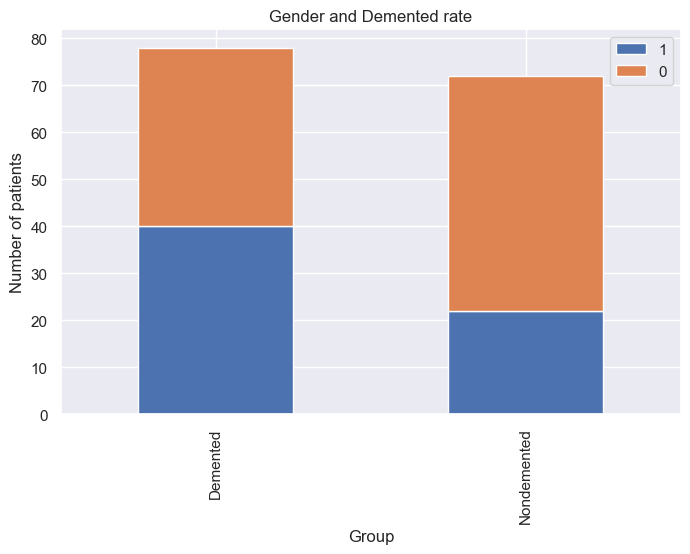

In [11]:
# bar drawing function
def bar_chart(feature):
    Demented = df[df['Group']==1][feature].value_counts()
    Nondemented = df[df['Group']==0][feature].value_counts()
    df_bar = pd.DataFrame([Demented,Nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True, figsize=(8,5))
# Gender  and  Group ( Femal=0, Male=1)
bar_chart('M/F')
plt.xlabel('Group')
plt.ylabel('Number of patients')
plt.legend()
plt.title('Gender and Demented rate')
print("\tThe Below graph indicates that men are more likely with dementia than women.")

***3.2 Nondemented Group Significantly Outperformed the Demented Group in MMSE Scores***

		The chart shows Nondemented group got much more higher MMSE scores than Demented group.


(15.3, 30.0)

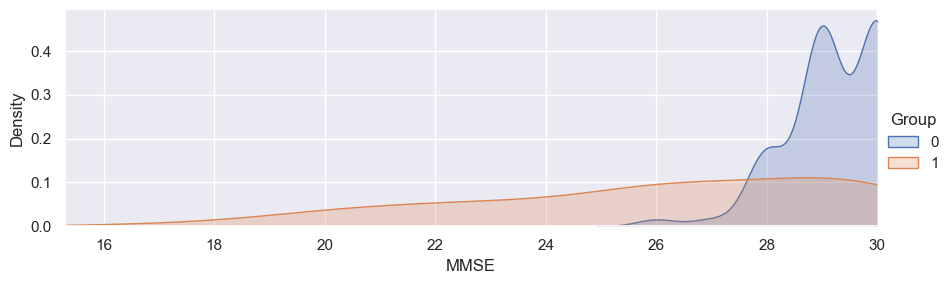

In [12]:
#MMSE : Mini Mental State Examination
# Nondemented = 0, Demented =1
# Nondemented has higher test result ranging from 25 to 30.
#Min 17 ,MAX 30
print("\t\tThe chart shows Nondemented group got much more higher MMSE scores than Demented group.")
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'MMSE',fill= True)
facet.set(xlim=(0, df['MMSE'].max()))
facet.add_legend()
plt.xlim(15.30)

***3.2 Brain Volume Loss in Demented Patients: Evidence from Comparative Analysis***

		The chart indicates that Nondemented group has higher brain volume ratio than Demented group.
		  This is assumed to be because the diseases affect the brain to be shrinking its tissue.


(0.6, 0.9)

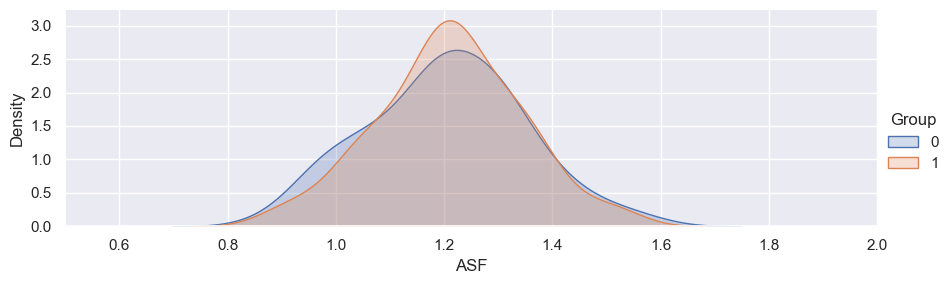

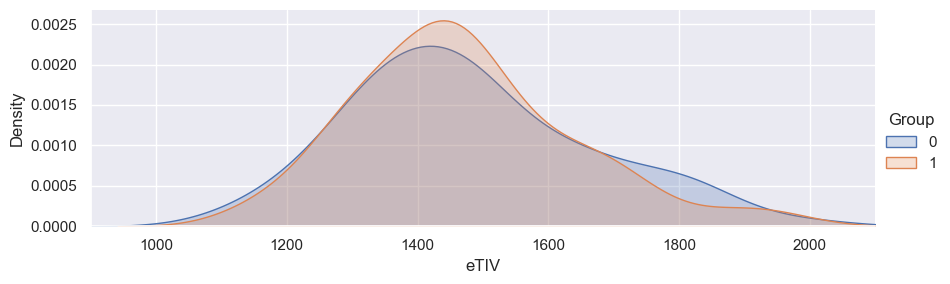

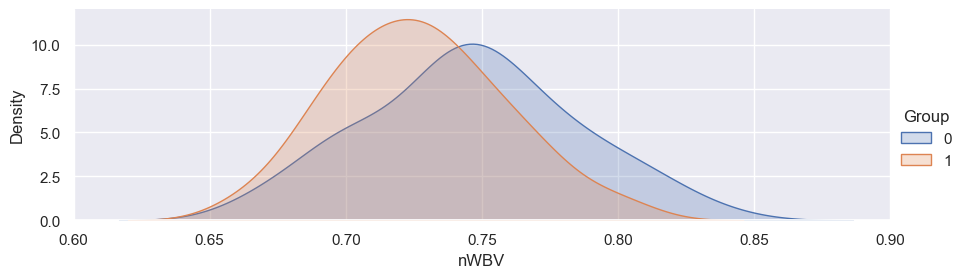

In [13]:
print("\t\tThe chart indicates that Nondemented group has higher brain volume ratio than Demented group.")
print("\t\t  This is assumed to be because the diseases affect the brain to be shrinking its tissue.")
#bar_chart('ASF') = Atlas Scaling Factor")
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'ASF',fill= True)
facet.set(xlim=(0, df['ASF'].max()))
facet.add_legend()
plt.xlim(0.5, 2)
#eTIV = Estimated Total Intracranial Volume
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'eTIV',fill= True)
facet.set(xlim=(0, df['eTIV'].max()))
facet.add_legend()
plt.xlim(900, 2100)
#'nWBV' = Normalized Whole Brain Volume
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'nWBV',fill= True)
facet.set(xlim=(0, df['nWBV'].max()))
facet.add_legend()
plt.xlim(0.6,0.9)

***3.3 Age-Related Decline in Survival Rate Among Demented Patients: A Tale of Vulnerability and Reduced Longevity***

	 There is a higher concentration of 70-80 years old in the Demented patient group than those in the nondemented patients.
	 We guess patients who suffered from that kind of disease has lower survival rate so that there are a few of 90 years old.


(50.0, 100.0)

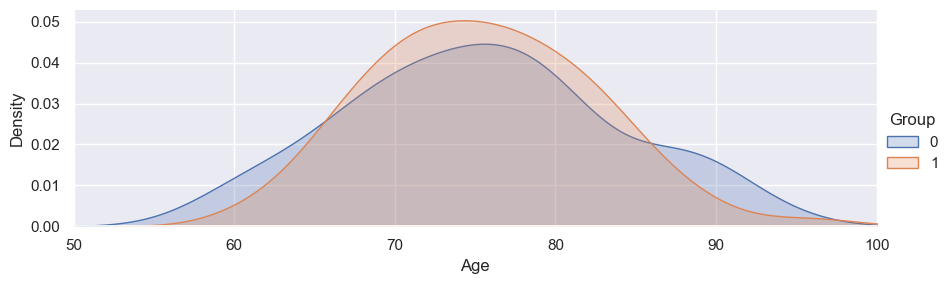

In [14]:
print("\t There is a higher concentration of 70-80 years old in the Demented patient group than those in the nondemented patients.")
print("\t We guess patients who suffered from that kind of disease has lower survival rate so that there are a few of 90 years old.")
#AGE. Nondemented =0, Demented =0
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'Age',fill= True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()
plt.xlim(50,100)

***3.4 Exploring Educational Attainment among Demented and Non-Demented Individuals***

This graph is a faceted KDE plot that shows the distribution of education years for two groups (non-demented and demented).


(0.0, 0.16)

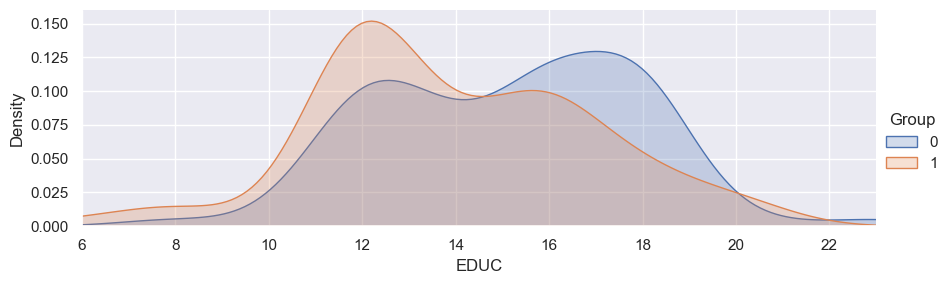

In [15]:
print("This graph is a faceted KDE plot that shows the distribution of education years for two groups (non-demented and demented).")
#'EDUC' = Years of Education
# Nondemented = 0, Demented =1
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'EDUC',fill= True)
facet.set(xlim=(df['EDUC'].min(), df['EDUC'].max()))
facet.add_legend()
plt.ylim(0, 0.16)

# ***4. Data Preprocessing***

***4.1 Imputation***

Scikit-learn provides package for imputation [6], but we do it manually. Since the SES is a discrete variable, we use median for the imputation.

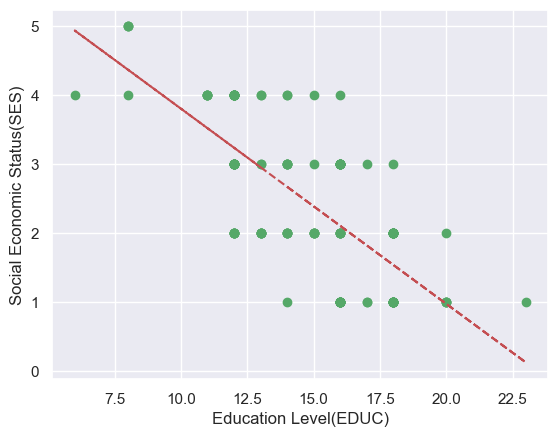

In [16]:
# Draw scatter plot between EDUC and SES
x = df['EDUC']
y = df['SES']

ses_not_null_index = y[~y.isnull()].index
x = x[ses_not_null_index]
y = y[ses_not_null_index]

# Draw trend line in red
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, y, 'go', x, p(x), "r--")
plt.xlabel('Education Level(EDUC)')
plt.ylabel('Social Economic Status(SES)')

plt.show()

In [17]:
df.groupby(['EDUC'])['SES'].median()

EDUC
6     4.0
8     5.0
11    4.0
12    3.0
13    2.0
14    3.0
15    2.0
16    2.0
17    1.0
18    2.0
20    1.0
23    1.0
Name: SES, dtype: float64

In [18]:
df["SES"].fillna(df.groupby("EDUC")["SES"].transform("median"), inplace=True)

C:\Users\sujal\AppData\Local\Temp\ipykernel_16392\2504912509.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["SES"].fillna(df.groupby("EDUC")["SES"].transform("median"), inplace=True)


In [19]:
# I confirm there're no more missing values and all the 150 data were used.
pd.isnull(df['SES']).value_counts()

SES
False    150
Name: count, dtype: int64

***4.2 Splitting Train / Validation / Test Sets***

In [20]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

In [21]:
# Dataset with imputation
Y = df['Group'].values # Target for the model
X = df[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)
# Save the scaler to a pickle file
joblib.dump(scaler, 'scaler.pkl')

print("Scaler saved as scaler.pkl")

Scaler saved as scaler.pkl


In [22]:
# Dataset after dropping missing value rows
Y = df_dropna['Group'].values # Target for the model
X = df_dropna[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']] # Features we use

# splitting into three sets
X_trainval_dna, X_test_dna, Y_trainval_dna, Y_test_dna = train_test_split(
    X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval_dna)
X_trainval_scaled_dna = scaler.transform(X_trainval_dna)
X_test_scaled_dna = scaler.transform(X_test_dna)

***4.3 Cross-validation***

We conduct 5-fold cross-validation to figure out the best parameters for each model, Logistic Regression, SVM, Decision Tree, Random Forests, and AdaBoost. Since our performance metric is accuracy, we find the best tuning parameters by accuracy. In the end, we compare the accuracy, recall and AUC for each model.

# ***5. Model Building***

***5.1 Performance Measures***

We use area under the receiver operating characteristic curve (AUC) as our main performance measure. We believe that in case of medical diagnostics for non-life threatening terminal diseases like most neurodegenerative diseases it is important to have a high true positive rate so that all patients with alzheimer's are identified as early as possible. But we also want to make sure that the false positive rate is as low as possible since we do not want to misdiagnose a healthy adult as demented and begin medical therapy. Hence AUC seemed like a ideal choice for a performance measure.

We will also be looking at accuracy and recall for each model.

In the figure below, you can think relevant elements as actually demented subjects. Precision and Recall.

<img src="https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg">

***5.2 Importing the Models***

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
from sklearn.model_selection import cross_val_score

In [24]:
acc = [] # list to store all performance metric

***5.3 Logistic Regression***


The parameter C, inverse of regularization strength.

Tuning range: [0.001, 0.1, 1, 10, 100]

c:\Users\sujal\anaconda3\envs\diseaseml\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\sujal\anaconda3\envs\diseaseml\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

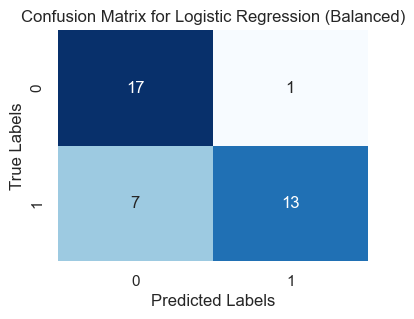

Logistic Regression (Balanced)
Best AUC on validation set: 0.8618044077134985
Best parameter for regularization (C): 10
Test accuracy with best C parameter: 0.7631578947368421
Test recall with the best C parameter: 0.65
Test AUC with the best C parameter: 0.8333333333333335
Optimal threshold: 0.5568420090861969
Model and results saved to 'logistic_regression_model.pkl'


In [25]:
from sklearn.metrics import confusion_matrix, recall_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Set the regularization parameter candidates
C_values = [0.001, 0.1, 1, 10, 100]

# Initialize variables to track the best score and parameters
best_score = 0
best_parameters = None

# Set the number of folds
kfolds = 5

# Perform cross-validation for each C value
for c in C_values:
    logRegModel = LogisticRegression(C=c, max_iter=1000, class_weight='balanced')
    scores = cross_val_score(logRegModel, X_trainval, Y_trainval, cv=kfolds, scoring='roc_auc')
    score = np.mean(scores)

    # Update best score and parameters if needed
    if score > best_score:
        best_score = score
        best_parameters = c

# Rebuild the model using the best parameter
SelectedLogRegModel = LogisticRegression(C=best_parameters, max_iter=1000, class_weight='balanced').fit(X_trainval_scaled, Y_trainval)

# Evaluate on the test set
test_score = SelectedLogRegModel.score(X_test_scaled, Y_test)
probas = SelectedLogRegModel.predict_proba(X_test_scaled)
fpr, tpr, thresholds = roc_curve(Y_test, probas[:, 1], pos_label=1)
test_auc = auc(fpr, tpr)

# Find the optimal threshold from the ROC curve
optimal_threshold = thresholds[np.argmax(tpr - fpr)]
PredictedOutput = (probas[:, 1] > optimal_threshold).astype(int)

# Calculate test recall and confusion matrix
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
conf_matrix = confusion_matrix(Y_test, PredictedOutput)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Logistic Regression (Balanced)")
plt.show()

# Print results
print("Logistic Regression (Balanced)")
print("Best AUC on validation set:", best_score)
print("Best parameter for regularization (C):", best_parameters)
print("Test accuracy with best C parameter:", test_score)
print("Test recall with the best C parameter:", test_recall)
print("Test AUC with the best C parameter:", test_auc)
print("Optimal threshold:", optimal_threshold)

# Save the model and other relevant objects
with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump({
        'model': SelectedLogRegModel,
        'best_score': best_score,
        'best_parameters': best_parameters,
        'test_score': test_score,
        'test_recall': test_recall,
        'test_auc': test_auc,
        'conf_matrix': conf_matrix,
        'optimal_threshold': optimal_threshold
    }, f)

print("Model and results saved to 'logistic_regression_model.pkl'")



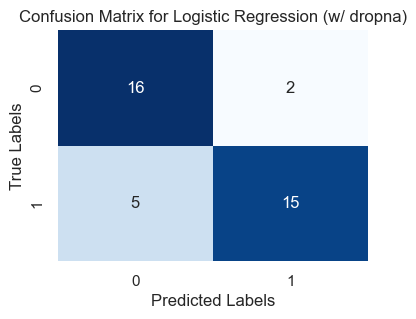

Logistic Regression (w/ dropna)
Best accuracy on validation set is: 0.725974025974026
Best parameter for regularization (C) is:  10
Test accuracy with best C parameter is 0.8055555555555556
Test recall with the best C parameter is 0.75
Test AUC with the best C parameter is 0.8194444444444443


In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Dataset after dropping missing value rows
best_score=0
kfolds=5 # set the number of folds

for c in [0.001, 0.1, 1, 10, 100]:
    logRegModel = LogisticRegression(C=c)
    # perform cross-validation
    scores = cross_val_score(logRegModel, X_trainval_scaled_dna, Y_trainval_dna, cv=kfolds, scoring='accuracy')

    # compute mean cross-validation accuracy
    score = np.mean(scores)

    # Find the best parameters and score
    if score > best_score:
        best_score = score
        best_parameters = c

# rebuild a model on the combined training and validation set
SelectedLogRegModel = LogisticRegression(C=best_parameters).fit(X_trainval_scaled_dna, Y_trainval_dna)

test_score = SelectedLogRegModel.score(X_test_scaled_dna, Y_test_dna)
PredictedOutput = SelectedLogRegModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, PredictedOutput)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(4, 3))  # Adjust the figure size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Logistic Regression (w/ dropna)")
plt.show()
print("Logistic Regression (w/ dropna)")
print("Best accuracy on validation set is:", best_score)
print("Best parameter for regularization (C) is: ", best_parameters)
print("Test accuracy with best C parameter is", test_score)
print("Test recall with the best C parameter is", test_recall)
print("Test AUC with the best C parameter is", test_auc)

m = 'Logistic Regression (w/ dropna)'
acc.append([m, test_score, test_recall, test_recall, fpr, tpr, thresholds])

In overall, dataset with imputation outperforms the one without imputation. For the later models, we use dataset without imputation.

***5.4 Support Vector Machine (SVM)***

Penalty parameter C of the error term. [0.001, 0.01, 0.1, 1, 10, 100, 1000]

gamma: kernel coefficient. [0.001, 0.01, 0.1, 1, 10, 100, 1000]

kernel: kernel type. ['rbf', 'linear', 'poly', 'sigmoid']

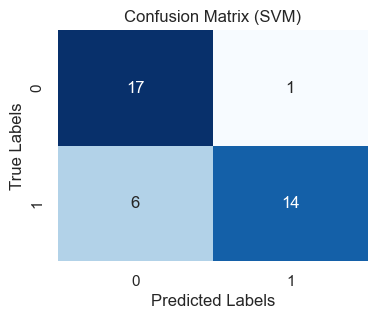

Support Vector Machine (SVM)
Best accuracy on cross validation set is: 0.7687747035573123
Best parameter for c is:  100
Best parameter for gamma is:  0.1
Best parameter for kernel is:  rbf
Test accuracy with the best parameters is 0.8157894736842105
Test recall with the best parameters is 0.7
Test recall with the best parameter is 0.8222222222222222


In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

best_score = 0

for c_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter C
    for gamma_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]: #iterate over the values we need to try for the parameter gamma
        for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']: # iterate over the values we need to try for the kernel parameter
            svmModel = SVC(kernel=k_parameter, C=c_paramter, gamma=gamma_paramter, probability=True) #define the model
            # perform cross-validation
            scores = cross_val_score(svmModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
            # the training set will be split internally into training and cross validation

            # compute mean cross-validation accuracy
            score = np.mean(scores)
            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score #store the score
                best_parameter_c = c_paramter #store the parameter c
                best_parameter_gamma = gamma_paramter #store the parameter gamma
                best_parameter_k = k_parameter


# rebuild a model with best parameters to get score
SelectedSVMmodel = SVC(C=best_parameter_c, gamma=best_parameter_gamma, kernel=best_parameter_k, probability=True)
SelectedSVMmodel.fit(X_trainval_scaled, Y_trainval)  # <--- You missed this line
test_score = SelectedSVMmodel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedSVMmodel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)


# Save the trained SVM model to pickle file
joblib.dump(SelectedSVMmodel, 'svm_model.pkl')  # Add this line


# Calculate the confusion matrix
conf_matrix_svm = confusion_matrix(Y_test, PredictedOutput)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (SVM)")
plt.show()
print(("Support Vector Machine (SVM)"))
print("Best accuracy on cross validation set is:", best_score)
print("Best parameter for c is: ", best_parameter_c)
print("Best parameter for gamma is: ", best_parameter_gamma)
print("Best parameter for kernel is: ", best_parameter_k)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is", test_recall)
print("Test recall with the best parameter is", test_auc)

m = 'SVM'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

***5.5 Decision Tree Classifier (DTC)***

Maximum depth. [1, 2, ..., 8]

8 is the number of features

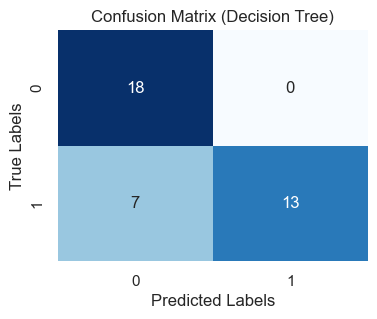

Decision Tree
Best accuracy on validation set is: 0.7770750988142293
Best parameter for the maximum depth is:  1
Test accuracy with best parameter is  0.8157894736842105
Test recall with best parameters is  0.65
Test AUC with the best parameter is  0.825


In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

best_score = 0

for md in range(1, 9): # iterate different maximum depth values
    # train the model
    treeModel = DecisionTreeClassifier(random_state=0, max_depth=md, criterion='gini')
    # perform cross-validation
    scores = cross_val_score(treeModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

    # compute mean cross-validation accuracy
    score = np.mean(scores)

    # if we got a better score, store the score and parameters
    if score > best_score:
        best_score = score
        best_parameter = md

# Rebuild a model on the combined training and validation set
SelectedDTModel = DecisionTreeClassifier(max_depth=best_parameter).fit(X_trainval_scaled, Y_trainval )

test_score = SelectedDTModel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedDTModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
joblib.dump(SelectedDTModel, 'dt_model.pkl')
# Calculate the confusion matrix
conf_matrix_dt = confusion_matrix(Y_test, PredictedOutput)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Decision Tree)")
plt.show()
print('Decision Tree')
print("Best accuracy on validation set is:", best_score)
print("Best parameter for the maximum depth is: ", best_parameter)
print("Test accuracy with best parameter is ", test_score)
print("Test recall with best parameters is ", test_recall)
print("Test AUC with the best parameter is ", test_auc)

m = 'Decision Tree'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

In [29]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(SelectedDTModel.feature_importances_)]).T

Feature importance: 


array([['M/F', '0.0'],
       ['Age', '0.0'],
       ['EDUC', '0.0'],
       ['SES', '0.0'],
       ['MMSE', '1.0'],
       ['eTIV', '0.0'],
       ['nWBV', '0.0'],
       ['ASF', '0.0']], dtype='<U32')

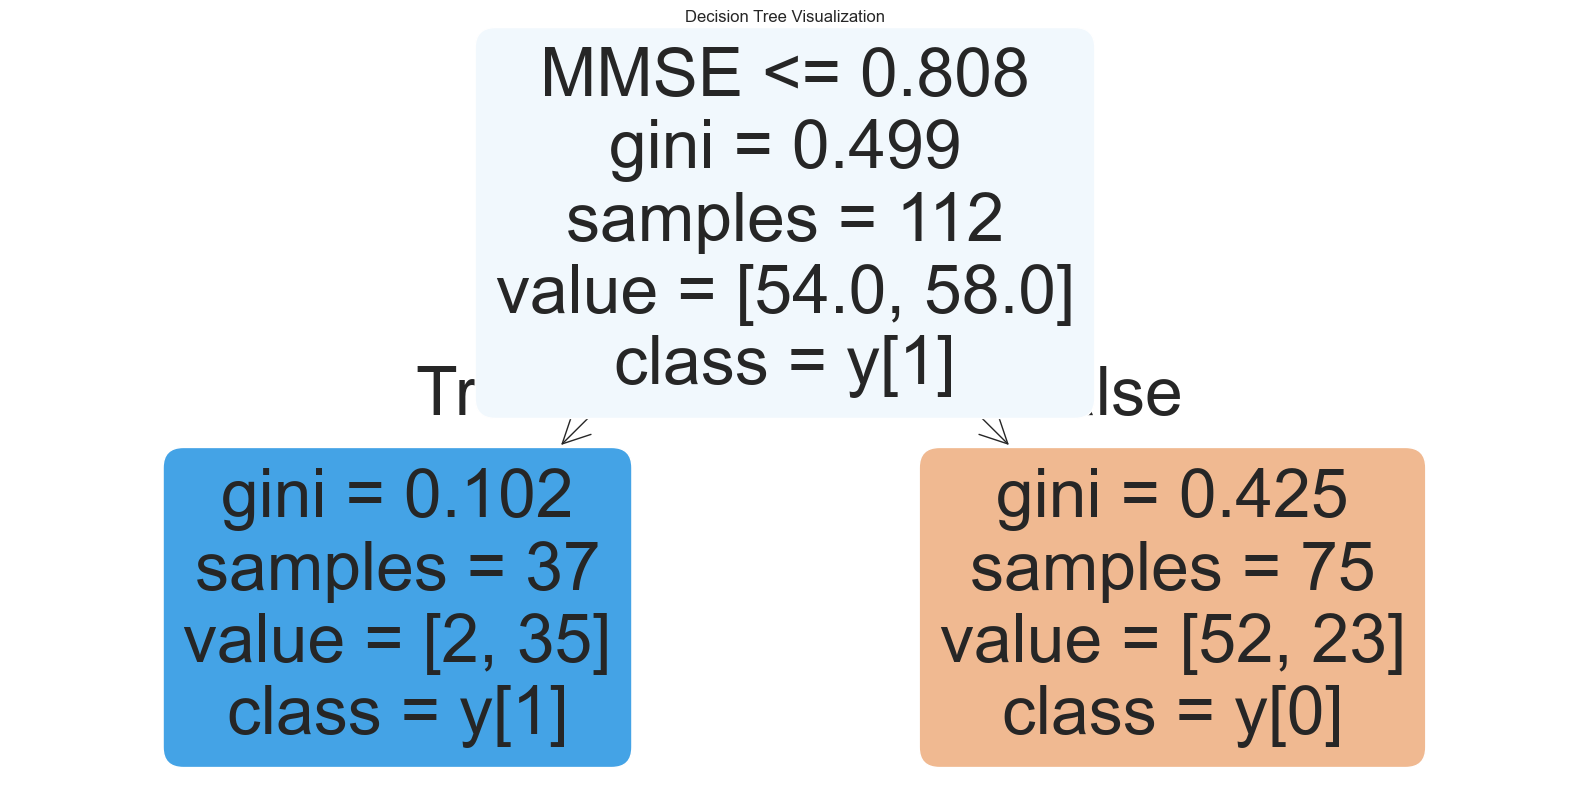

In [30]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    SelectedDTModel,
    feature_names=X_trainval.columns.tolist(),
    filled=True,
    rounded=True,
    class_names=True  # or pass class names if available
)
plt.title("Decision Tree Visualization")
plt.show()

***5.6 Random Forest Classifier (RFC)***

n_estimators(M): the number of trees in the forest

max_features(d): the number of features to consider when looking for the best split

max_depth(m): the maximum depth of the tree.

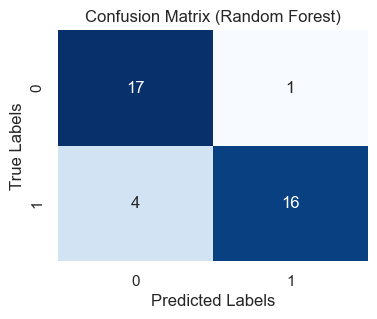

Random Forest
Best accuracy on validation set is: 0.8035573122529645
Best parameters of M, d, m are:  2 5 7
Test accuracy with the best parameters is 0.868421052631579
Test recall with the best parameters is: 0.8
Test AUC with the best parameters is: 0.8722222222222222


In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
best_score = 0

for M in range(2, 15, 2): # combines M trees
    for d in range(1, 9): # maximum number of features considered at each split
        for m in range(1, 9): # maximum depth of the tree
            # train the model
            # n_jobs(4) is the number of parallel computing
            forestModel = RandomForestClassifier(n_estimators=M, max_features=d, n_jobs=4,
                                          max_depth=m, random_state=0)

            # perform cross-validation
            scores = cross_val_score(forestModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

            # compute mean cross-validation accuracy
            score = np.mean(scores)

            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score
                best_M = M
                best_d = d
                best_m = m

# Rebuild a model on the combined training and validation set
SelectedRFModel = RandomForestClassifier(n_estimators=M, max_features=d,
                                          max_depth=m, random_state=0).fit(X_trainval_scaled, Y_trainval )

PredictedOutput = SelectedRFModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
joblib.dump(SelectedRFModel, 'rf_model.pkl')
# Calculate the confusion matrix
conf_matrix_rf = confusion_matrix(Y_test, PredictedOutput)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Random Forest)")
plt.show()
print('Random Forest')
print("Best accuracy on validation set is:", best_score)
print("Best parameters of M, d, m are: ", best_M, best_d, best_m)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)

m = 'Random Forest'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

In [32]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(SelectedRFModel.feature_importances_)]).T

Feature importance: 


array([['M/F', '0.03503132427481025'],
       ['Age', '0.09551237125526228'],
       ['EDUC', '0.06261556797214127'],
       ['SES', '0.060620327518549066'],
       ['MMSE', '0.4006565962793097'],
       ['eTIV', '0.07005497528287095'],
       ['nWBV', '0.1460571117936201'],
       ['ASF', '0.1294517256234364']], dtype='<U32')

***5.7 Adaptive Boosting Classifier (Adaboost)***

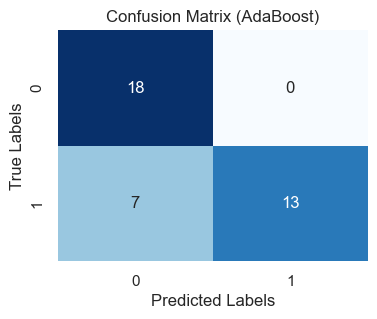

AdaBoost
Best accuracy on validation set is: 0.7770750988142293
Best parameter of M is:  2
best parameter of LR is:  0.0001
Test accuracy with the best parameter is 0.868421052631579
Test recall with the best parameters is: 0.65
Test AUC with the best parameters is: 0.825


In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

best_score = 0

for M in range(2, 15, 2): # combines M trees
    for lr in [0.0001, 0.001, 0.01, 0.1, 1]:
        # train the model
        boostModel = AdaBoostClassifier(n_estimators=M, learning_rate=lr, random_state=0)

        # perform cross-validation
        scores = cross_val_score(boostModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')

        # compute mean cross-validation accuracy
        score = np.mean(scores)

        # if we got a better score, store the score and parameters
        if score > best_score:
            best_score = score
            best_M = M
            best_lr = lr

# Rebuild a model on the combined training and validation set
SelectedBoostModel = AdaBoostClassifier(n_estimators=best_M, learning_rate=best_lr, random_state=0).fit(X_trainval_scaled, Y_trainval)
PredictedOutput = SelectedBoostModel.predict(X_test_scaled)
test_score = SelectedRFModel.score(X_test_scaled, Y_test)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
joblib.dump(SelectedBoostModel, 'boost_model.pkl')
# Calculate the confusion matrix
conf_matrix_boost = confusion_matrix(Y_test, PredictedOutput)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix_boost, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (AdaBoost)")
plt.show()
print('AdaBoost')
print("Best accuracy on validation set is:", best_score)
print("Best parameter of M is: ", best_M)
print("best parameter of LR is: ", best_lr)
print("Test accuracy with the best parameter is", test_score)
print("Test recall with the best parameters is:", test_recall)
print("Test AUC with the best parameters is:", test_auc)
m = 'AdaBoost'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

In [34]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(SelectedBoostModel.feature_importances_)]).T

Feature importance: 


array([['M/F', '0.0'],
       ['Age', '0.0'],
       ['EDUC', '0.0'],
       ['SES', '0.0'],
       ['MMSE', '1.0'],
       ['eTIV', '0.0'],
       ['nWBV', '0.0'],
       ['ASF', '0.0']], dtype='<U32')

# ***6. Conclusion***

***6.1 Results***

In [35]:
# Performance Metric for each model
result = pd.DataFrame(acc, columns=['Model', 'Accuracy', 'Recall', 'AUC', 'FPR', 'TPR', 'TH'])
result[['Model', 'Accuracy', 'Recall', 'AUC']]

,Model,Accuracy,Recall,AUC
0,Logistic Regression (w/ dropna),0.805556,0.75,0.750000
1,SVM,0.815789,0.70,0.822222
2,Decision Tree,0.815789,0.65,0.825000
3,Random Forest,0.868421,0.80,0.872222
4,AdaBoost,0.868421,0.65,0.825000


***6.2 Unique Approach***

The uniqueness of our approach is the fact that we would be including metrices like MMSE and Education also in our model to train it to differentiate between normal healthy adults and those with Alzheimer's. MMSE is one of the gold standards for determining dementia and hence we think it is an important feature to include.

The same fact also make our approach flexible enough to be applied to other neurodegenerative diseases which are diagnosed using a combination of MRI features and cognitive tests.

***6.3 Accuracy Comparsion Of Different ModeL***

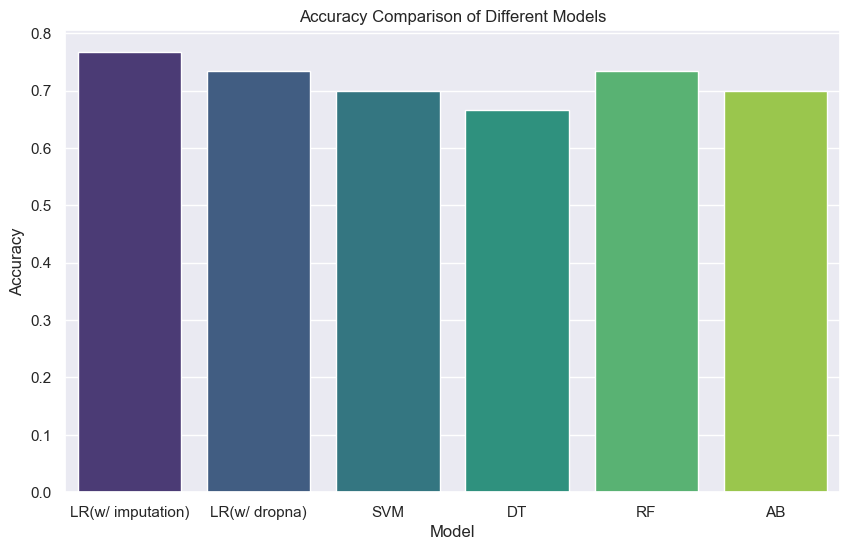

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
model_names = ['LR(w/ imputation)', 'LR(w/ dropna)', 'SVM', 'DT', 'RF', 'AB']
accuracy = [0.7666666666666667, 0.7333333333333333, 0.7, 0.6666666666666666, 0.7333333333333333, 0.7]
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy, palette='viridis', hue=model_names, legend=False)
plt.title('Accuracy Comparison of Different Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

***6.4 Model Comparison Metrics***

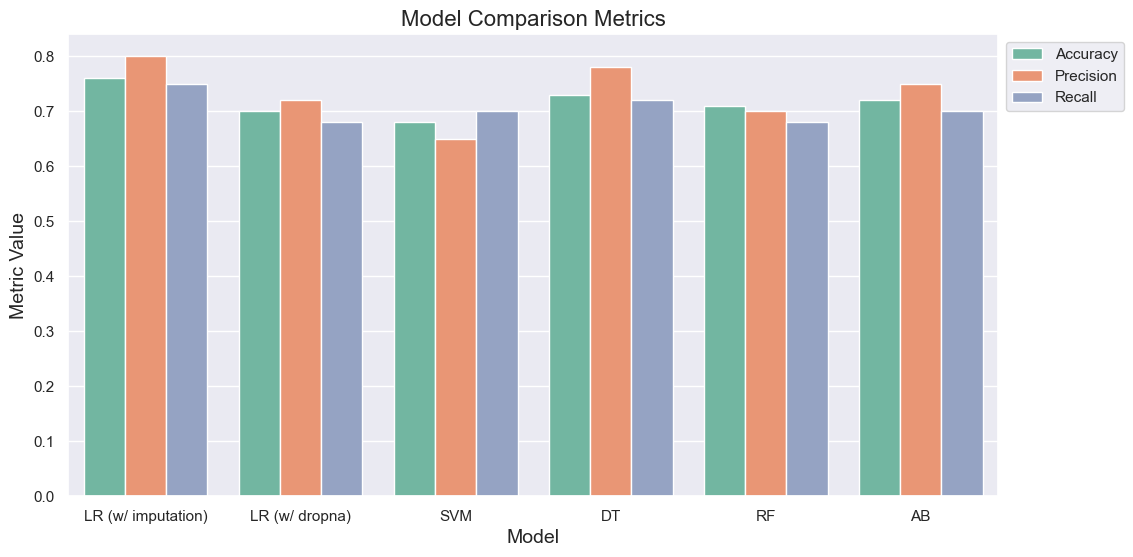

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
# Sample data (replace with your actual data)
model_abbreviations = ['LR (w/ imputation)', 'LR (w/ dropna)', 'SVM', 'DT', 'RF', 'AB']
accuracy_scores = [0.76, 0.70, 0.68, 0.73, 0.71, 0.72]
precision_scores = [0.80, 0.72, 0.65, 0.78, 0.70, 0.75]
recall_scores = [0.75, 0.68, 0.70, 0.72, 0.68, 0.70]
# Create a DataFrame for the metrics
import pandas as pd
metrics_df = pd.DataFrame({
    'Model': model_abbreviations * 3,
    'Metric': ['Accuracy'] * len(model_abbreviations) + ['Precision'] * len(model_abbreviations) + ['Recall'] * len(model_abbreviations),
    'Score': accuracy_scores + precision_scores + recall_scores
})
# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=metrics_df, palette='Set2')
# Add title and labels
plt.title("Model Comparison Metrics", fontsize=16)
plt.xlabel("Model", fontsize=14)
plt.ylabel("Metric Value", fontsize=14)
# Move the legend to the right
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Show the plot
plt.show()

***6.5 Model Comparison Metrics In Terms Of Heat Map***


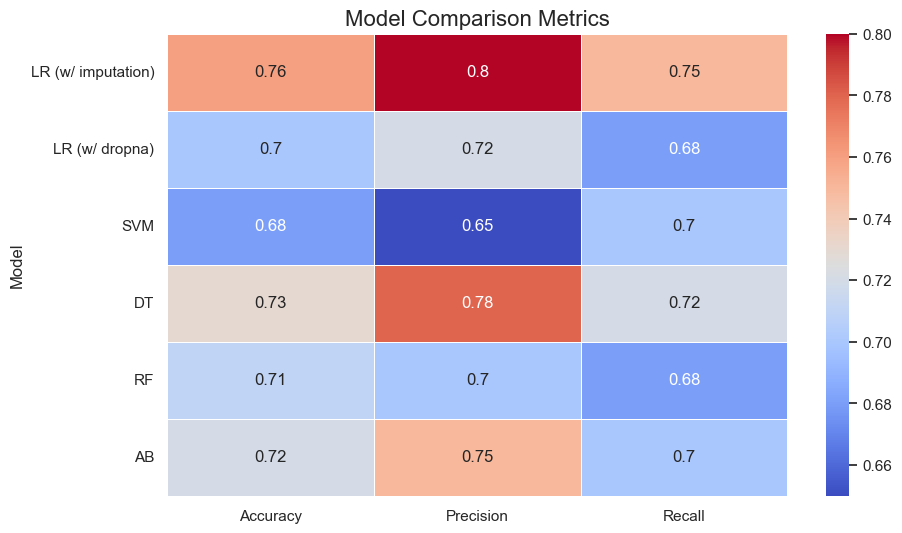

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Sample data (replace with your actual data)
model_abbreviations = ['LR (w/ imputation)', 'LR (w/ dropna)', 'SVM', 'DT', 'RF', 'AB']
accuracy_scores = [0.76, 0.70, 0.68, 0.73, 0.71, 0.72]
precision_scores = [0.80, 0.72, 0.65, 0.78, 0.70, 0.75]
recall_scores = [0.75, 0.68, 0.70, 0.72, 0.68, 0.70]
# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Model': model_abbreviations,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores
})
# Set the index to the model names
metrics_df.set_index('Model', inplace=True)
# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap='coolwarm', linewidths=0.5)
# Add title
plt.title("Model Comparison Metrics", fontsize=16)
# Show the plot
plt.show()

In [39]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Sample data
patient_data = [123, 'MRI_001', 'AD', 1, 0, 'M', 'R', 75, 16, 2, 24, 0.5, 1500, 1200, 1.2]

# Columns corresponding to the patient data
# Ensure these columns match the features used during model training
columns = ['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F',
           'Hand', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']

# Create a DataFrame for the patient data
patient_df = pd.DataFrame([patient_data], columns=columns)

# Identify categorical columns
categorical_cols = ['MRI ID', 'Group', 'M/F', 'Hand']

# Apply label encoding to categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    patient_df[col] = le.fit_transform(patient_df[col])
    label_encoders[col] = le

# Select only the features used during training for prediction
# Replace with the actual columns used during training
training_features = ['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
patient_data_encoded = patient_df[training_features].values

def predict_alzheimer(patient_data):
    # Assuming 'SelectedLogRegModel' is a trained logistic regression model
    prediction = SelectedLogRegModel.predict(patient_data)

    # Interpret the prediction
    if prediction[0] == 1:
        return "High Risk of Alzheimer's"
    else:
        return "Low Risk of Alzheimer's"

# Make the prediction using the encoded data
prediction = predict_alzheimer(patient_data_encoded)
print(prediction)

Low Risk of Alzheimer's


In [40]:
"""import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Columns corresponding to the patient data
columns = ['Subject ID', 'MRI ID', 'Group', 'Visit', 'MR Delay', 'M/F',
           'Hand', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']

# Function to get patient data from user input with explanations
def get_patient_data():
    explanations = {
        'Subject ID': 'Unique identifier for each subject (e.g., 123)',
        'MRI ID': 'Identifier for each MRI scan (e.g., MRI_001)',
        'Group': 'Classification of subjects (Nondemented, Demented)',
        'Visit': 'Visit number (e.g., 1)',
        'MR Delay': 'Delay in days between visits (e.g., 0)',
        'M/F': 'Gender (M for Male, F for Female)',
        'Hand': 'Handedness (R for Right, L for Left)',
        'Age': 'Age of the subject (e.g., 75)',
        'EDUC': 'Years of education (e.g., 16)',
        'SES': 'Socioeconomic status (scale from 1 to 5, e.g., 2)',
        'MMSE': 'Mini-Mental State Examination score (scale from 0 to 30, e.g., 24)',
        'CDR': 'Clinical Dementia Rating (scale from 0 to 3, e.g., 0.5)',
        'eTIV': 'Estimated Total Intracranial Volume (e.g., 1500)',
        'nWBV': 'Normalized Whole Brain Volume (e.g., 0.8)',
        'ASF': 'Atlas Scaling Factor (e.g., 1.2)'
    }

    patient_data = []
    for col in columns:
        value = input(f"Enter {col} ({explanations[col]}): ")
        patient_data.append(value)
    return patient_data

# Function to preprocess patient data
def preprocess_patient_data(patient_data):
    # Create a DataFrame for the patient data
    patient_df = pd.DataFrame([patient_data], columns=columns)

    # Identify categorical columns
    categorical_cols = ['MRI ID', 'Group', 'M/F', 'Hand']

    # Apply label encoding to categorical columns
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        patient_df[col] = le.fit_transform(patient_df[col])
        label_encoders[col] = le

    # Select only the features used during training for prediction
    training_features = ['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
    patient_data_encoded = patient_df[training_features].values

    return patient_data_encoded

# Function to predict Alzheimer's risk
def predict_alzheimer(patient_data):
    # Assuming 'SelectedLogRegModel' is a trained logistic regression model
    prediction = SelectedLogRegModel.predict(patient_data)

    # Interpret the prediction
    if prediction[0] == 1:
        return "High Risk of Alzheimer's"
    else:
        return "Low Risk of Alzheimer's"

# Get patient data from user input
patient_data = get_patient_data()

# Preprocess the patient data
patient_data_encoded = preprocess_patient_data(patient_data)

# Make the prediction using the encoded data
prediction = predict_alzheimer(patient_data_encoded)
print(prediction)"""


'import pandas as pd\nfrom sklearn.preprocessing import LabelEncoder\n\n# Columns corresponding to the patient data\ncolumns = [\'Subject ID\', \'MRI ID\', \'Group\', \'Visit\', \'MR Delay\', \'M/F\',\n           \'Hand\', \'Age\', \'EDUC\', \'SES\', \'MMSE\', \'CDR\', \'eTIV\', \'nWBV\', \'ASF\']\n\n# Function to get patient data from user input with explanations\ndef get_patient_data():\n    explanations = {\n        \'Subject ID\': \'Unique identifier for each subject (e.g., 123)\',\n        \'MRI ID\': \'Identifier for each MRI scan (e.g., MRI_001)\',\n        \'Group\': \'Classification of subjects (Nondemented, Demented)\',\n        \'Visit\': \'Visit number (e.g., 1)\',\n        \'MR Delay\': \'Delay in days between visits (e.g., 0)\',\n        \'M/F\': \'Gender (M for Male, F for Female)\',\n        \'Hand\': \'Handedness (R for Right, L for Left)\',\n        \'Age\': \'Age of the subject (e.g., 75)\',\n        \'EDUC\': \'Years of education (e.g., 16)\',\n        \'SES\': \'So

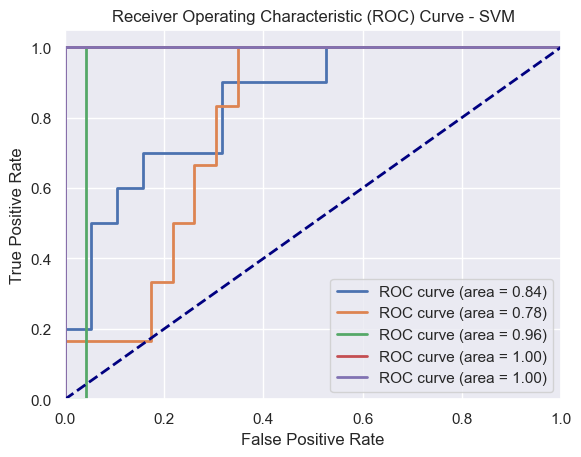

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Assuming you have your original data in X and y
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Binarize the target variable for multiclass ROC curve
Y_train_bin = label_binarize(Y_train, classes=y.unique())  # Get unique classes from original y
Y_test_bin = label_binarize(Y_test, classes=y.unique())

# Initialize and train the SVM model with OneVsRestClassifier
SelectedSVMmodel = OneVsRestClassifier(SVC(probability=True))
SelectedSVMmodel.fit(X_train_scaled, Y_train_bin)

def plot_roc_curve(model, X_test, y_test, model_name):
    """Plots the ROC curve for a given model (multiclass)."""
    n_classes = y_test.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], model.predict_proba(X_test)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = %0.2f)' % roc_auc[i])

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve - ' + model_name)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(SelectedSVMmodel, X_test_scaled, Y_test_bin, 'SVM')